In [1]:
# make the notebook more readable:
import warnings
warnings.filterwarnings('ignore')
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path:
    sys.path.append(module_path)

# Highly idealised setup

We will test our setup with more idealised boundary conditions. We use the konrad RCE model to generate initial temperature and moisture profiles.

## Create a profile

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from typhon import plots
import konrad

def get_konrad_atmosphere(T_s, co2_mult=1.0):
    plev, phlev = konrad.utils.get_pressure_grids(1000e2, 1, 128)
    atmosphere = konrad.atmosphere.Atmosphere(phlev)
    atmosphere['CO2'] = atmosphere['CO2'] * co2_mult
    initial = konrad.atmosphere.Atmosphere(phlev).to_dataset()
    # Initialize the setup for the radiative-convective equilibrium simulation.
    rce = konrad.RCE(
        atmosphere,
        surface=konrad.surface.FixedTemperature(temperature=T_s),  # Run with a fixed surface temperature.
        timestep='12h',  # Set timestep in model time.
        max_duration='100d',  # Set maximum runtime.
    )
    rce.run()
    return atmosphere.to_dataset()

konrad_control = get_konrad_atmosphere(300).isel(time=0)
# konrad_warm = get_konrad_atmosphere(304).isel(time=0)
konrad_control

<xarray.Dataset>
Dimensions:  (plev: 128, phlev: 129)
Coordinates:
    time     int64 0
  * plev     (plev) float64 9.776e+04 9.339e+04 8.916e+04 ... 1.398 1.223 1.07
  * phlev    (phlev) float64 1e+05 9.557e+04 9.127e+04 ... 1.308 1.144 1.0
Data variables: (12/13)
    T        (plev) float64 299.3 297.8 296.3 294.7 ... 189.0 183.1 174.2 159.6
    H2O      (plev) float64 0.02772 0.02657 0.02541 ... 1.832e-05 1.832e-05
    N2O      (plev) float64 3.06e-07 3.06e-07 3.06e-07 ... 3.06e-07 3.06e-07
    O3       (plev) float64 4.452e-41 2.004e-39 ... 9.337e-08 8.351e-08
    O2       (plev) float64 0.2095 0.2095 0.2095 0.2095 ... 0.2095 0.2095 0.2095
    CO2      (plev) float64 0.000348 0.000348 0.000348 ... 0.000348 0.000348
    ...       ...
    CH4      (plev) float64 1.65e-06 1.65e-06 1.65e-06 ... 1.65e-06 1.65e-06
    CFC11    (plev) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    CFC12    (plev) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    CFC22    (plev) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    CCl4     (plev) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    z        (plev) float64 200.8 608.2 1.02e+03 ... 8.088e+04 8.155e+04

Overview over the files we have to manipulate

In [3]:
import os
BASE_PATH = '/work/mh1126/m300872/unchanged/'

grid = dict()
for dom in ['DOM01','DOM02']:
    grid[dom] = xr.open_dataset(BASE_PATH+'grids/'+f'EUREC4A_PR1250m_{dom}.nc')
    print(dom, '  ncell:', grid[dom].cell.shape)
    
init_path = BASE_PATH+'initc/20200109/'+'initc_EUREC4A_PR1250m_DOM01_2020010910.nc'
init = xr.open_dataset(init_path)
print('initcon', 'ncell:', init.ncells.shape)

latbc_path = BASE_PATH+'latbc/lateral_boundary_DOM01.grid.nc'
latbc = xr.open_dataset(latbc_path)
print('latbc  ', 'ncell:', latbc.cell.shape)

DOM01   ncell: (4528560,)
DOM02   ncell: (11792076,)
initcon ncell: (4528560,)
latbc   ncell: (174068,)


Load a random latbc file.

In [4]:
def example_latbcfile():
    latbc_path = '/work/mh1126/m300872/unchanged/latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010801.nc'
    return xr.open_dataset(latbc_path)

latbc = example_latbcfile()

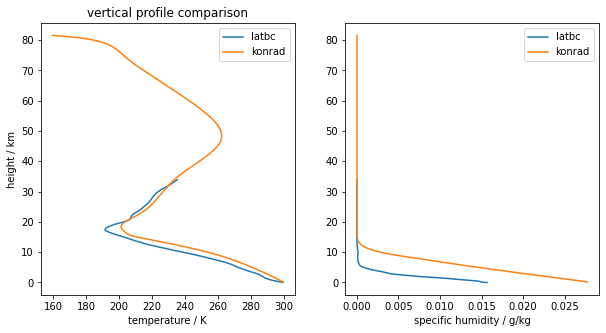

In [5]:
def interpolate_full_level(half_level):
    return np.asarray([(half_level[i]+half_level[i-1])/2 for i in range(1,len(half_level))])

def add_full_level(dataset):
    dataset['z'] = interpolate_full_level(dataset.z_ifc.values)
    return dataset

def fig_vertical_comparison(a,b):
    fig, axs = plt.subplots(1,2, figsize=(10,5))
    ax = axs[0]
    ax.set_title('vertical profile comparison')
    ax.plot(a['temp'].values, a['z'].values/1000, label='latbc')
    ax.plot(b['T'], b['z']/1000, label='konrad')
    ax.set_xlabel('temperature / K')
    ax.set_ylabel('height / km')
    ax.legend()
    ax = axs[1]
    ax.plot(a['qv'].values, a['z'].values/1000, label='latbc')
    ax.plot(b['H2O'], b['z'] /1000, label='konrad')
    ax.set_xlabel('specific humidity / g/kg')
    ax.legend()
    return fig, axs


profile = add_full_level(latbc.mean(dim=['time', 'ncells']))
fig, axs = fig_vertical_comparison(profile, konrad_control)
fig.show()

The konrad data reaches much higher into the atmosphere. The ICON vertical grid has a tighter spacing in the lower part.

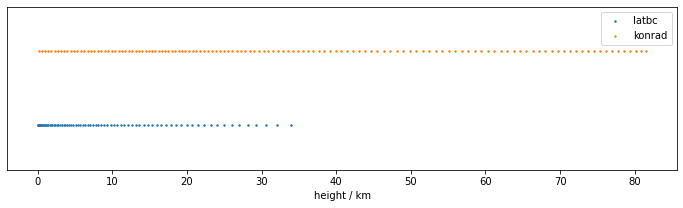

In [6]:
import plot_utils as pu

def fig_vertical_grid_spacing(a, b, xlim=False):
    fig, ax = plt.subplots(figsize=(12,3))
    ax.scatter(a.z.values/1000, np.ones(len(a.z.values)) * 0.5, s=2, label='latbc')
    ax.scatter(b.z.values/1000, np.ones(len(b.z.values)), s=2 , label='konrad')
    ax.set_ylim(0.2,1.3)
    if xlim: ax.set_xlim(*xlim)
    ax.set_xlabel('height / km')
    ax.legend()
    pu.remove_ticks(ax,['left', 'right'])
    return fig, ax

fig, ax = fig_vertical_grid_spacing(profile, konrad_control)
fig.show()

Now we have to find a method of regridding. The easiest solution will be nearest neighbor. A comparison to more accurate approaches like linear interpolation can be tested later. 

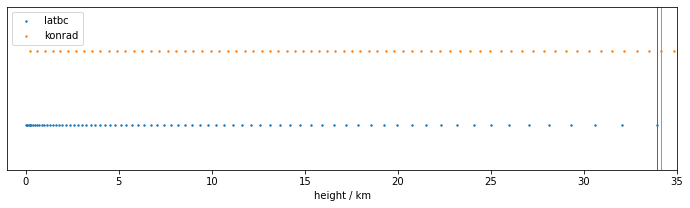

In [7]:
import random 

def find_nearest_index(array, value):
    difference_array = np.absolute(array - value)
    return difference_array.argmin()

def fig_vertical_grid_spacing_marked_line(a, b, xlim=(-1,35)):
    rand_index = random.randint(0, len(a.z.values))
    value = a.z.values[rand_index]
    array = b.z.values
    index = find_nearest_index(array, value)

    fig, ax = fig_vertical_grid_spacing(a, b, xlim=xlim)
    ax.axvline(value/1000, lw=1)
    ax.axvline(array[index]/1000, lw=1, color='tab:orange')
    return fig, ax

fig, ax = fig_vertical_grid_spacing_marked_line(profile, konrad_control)
fig.show()

In [8]:
def regrid_konrad_data(konrad_data, target_height_levels):
    regridded = dict()
    for key in ['pres', 'temp', 'qv']:
        regridded[key] = list()

    for z in target_height_levels:
        i = find_nearest_index(konrad_data.z.values, z)
        regridded['pres'].append(konrad_data['plev'].values[i])
        regridded['temp'].append(konrad_data['T'   ].values[i])
        regridded['qv'  ].append(konrad_data['H2O' ].values[i])
    return regridded

def zero_fields(dataset, zero_vars = ['w', 'qc', 'qi', 'qr', 'qs', 'u', 'v']):
    return_data = dataset.copy()
    for var in zero_vars:
        return_data[var].values *= 0.0
    return return_data

regridded = regrid_konrad_data(konrad_control, profile.z.values)


for i,e in enumerate(profile.temp.values):
    # print(profile.pres.values[i], '>>>', pres[i])
    # print(profile.temp.values[i], '>>>', temp[i])
    # print(profile.qv.values[i], '>>>', qv[i])dw
    pass

dataset = latbc.copy()

a = zero_fields(latbc)
latbc = example_latbcfile()
a

<xarray.Dataset>
Dimensions:        (time: 1, ncells: 174068, vertices: 3, height: 76, bnds: 2,
                    height_2: 76, height_3: 75)
Coordinates:
  * time           (time) datetime64[ns] 2020-01-08T01:00:00
    clon           (ncells) float64 ...
    clat           (ncells) float64 ...
  * height         (height) float64 1.0 2.0 3.0 4.0 5.0 ... 73.0 74.0 75.0 76.0
  * height_2       (height_2) float64 1.0 2.0 3.0 4.0 ... 73.0 74.0 75.0 76.0
  * height_3       (height_3) float64 1.0 2.0 3.0 4.0 ... 72.0 73.0 74.0 75.0
Dimensions without coordinates: ncells, vertices, bnds
Data variables: (12/15)
    clon_bnds      (ncells, vertices) float64 -0.7851 -0.7853 ... -1.051 -1.051
    clat_bnds      (ncells, vertices) float64 0.2736 0.2736 ... 0.1733 0.1734
    height_bnds    (height, bnds) float64 1.0 0.0 2.0 0.0 ... 75.0 0.0 76.0 0.0
    height_3_bnds  (height_3, bnds) float64 1.0 2.0 2.0 3.0 ... 75.0 75.0 76.0
    z_ifc          (time, height, ncells) float32 3.5e+04 3.5e+04 ... 0.0 0.0
    w              (time, height_2, ncells) float32 0.0 0.0 0.0 ... -0.0 0.0
    ...             ...
    qr             (time, height_3, ncells) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    qs             (time, height_3, ncells) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    u              (time, height_3, ncells) float32 -0.0 -0.0 -0.0 ... -0.0 -0.0
    v              (time, height_3, ncells) float32 0.0 0.0 0.0 ... -0.0 -0.0
    temp           (time, height_3, ncells) float32 230.9 230.9 ... 300.1 300.1
    pres           (time, height_3, ncells) float32 623.1 623.1 ... 1.014e+05
Attributes:
    CDI:             Climate Data Interface version 1.9.7 (http://mpimet.mpg....
    Conventions:     CF-1.6
    uuidOfHGrid:     f70a2faa-0fa0-b934-f7fc-f3b9e8c72f20
    uuidOfVGrid:     dea5fc13-f89b-ff83-beb9-afbd8add2e40
    source:          git@git.mpimet.mpg.de:dwd_icon_tools.git, branch master,...
    institution:     Max Planck Institute for Meteorology
    DWD ICON Tools:  git@git.mpimet.mpg.de:dwd_icon_tools.git :: master, rev....
    parent_file:     /work/bb1156/ICON-1.25km/DATA/2020010700/dei4_EUREC4a1_2...
    history:         Tue May  4 16:53:54 2021: ncatted -O -a parent_file,glob...
    NCO:             netCDF Operators version 4.9.3 (Homepage = http://nco.sf...

In [9]:
list(a.dims), len(regridded[var]), [f'{v}={a[v].shape}' for v in list(a)], [f'{v}={a[v].shape}' for v in (a.dims)]

NameError: name 'var' is not defined

In [ ]:
def replace_values_in_dataset(array, replacement):
    array = array.copy()
    for var in replacement.keys():    
        levels = np.asarray(range(len(replacement[var])))
        print(array[var].values.shape, len(replacement[var]))
        for l in levels:
            scheibe = slice(1, 75, 174068)
            array[var].values[scheibe] *= 0
            array[var].values[:,l,:] += replacement[var][l]
    return array
        
a = example_latbcfile()
a = replace_values_in_dataset(a, regridded)
        
fig, ax = plt.subplots()
ax.imshow(a[var].values[0,:,:])
ax.set_xlim(0,100)
fig.show()

In [ ]:
showstopper()

In [ ]:
import metpy.calc as mpcalc
from metpy.units import units

def add_prognostic_variables(dataset, varnames=None):
    varnames = add_varnames_to_default(varnames)
    p  = dataset[varnames['pressure']].values    * units('pascal')
    t  = dataset[varnames['temperature']].values * units('kelvin')
    qv = dataset[varnames['specific humidity']].values   # ratio of water vapor mass to total moist air parcel mass
    
    eps   = mpcalc.mixing_ratio_from_specific_humidity(qv)
    theta = mpcalc.virtual_potential_temperature(p,t,eps)
    rho   = mpcalc.density(p, t, eps)
    
    dimnames = dataset[varnames['temperature']].dims
    dataset[varnames['virtual potential temperature']] = (dimnames, theta.magnitude)
    dataset[varnames['density']] = (dimnames, rho.magnitude)
    return dataset


In [ ]:
T_s = 300; co2_mult = 1.0

plev, phlev = konrad.utils.get_pressure_grids(1000e2, 1, 128)
atmosphere = konrad.atmosphere.Atmosphere(phlev)
atmosphere['CO2'] = atmosphere['CO2'] * co2_mult
initial = konrad.atmosphere.Atmosphere(phlev).to_dataset()
# Initialize the setup for the radiative-convective equilibrium simulation.
rce = konrad.RCE(
    atmosphere,
    surface=konrad.surface.FixedTemperature(temperature=T_s),  # Run with a fixed surface temperature.
    timestep='12h',  # Set timestep in model time.
    max_duration='100d',  # Set maximum runtime.
)
rce.run()
atmosphere.calculate_height()

In [ ]:
fig, ax = plt.subplots()
ax.plot(konrad_control.T, konrad_control.z, color='r')
# ax.plot(konrad_warm.T, konrad_warm.z, color='r', ls=':')
ax = ax.twiny()
ax.plot(konrad_control.H2O, konrad_control.z, color='tab:blue')
# ax.plot(konrad_warm.H2O, konrad_warm.z, ls=':', color='tab:blue')
plt.show()

In [ ]:
# https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.add_pressure_to_height.html
# Calculate the height at a certain pressure above another height.
# This assumes a standard atmosphere [NOAA1976].
# height (pint.Quantity) – Height level
# pressure (pint.Quantity) – Pressure above height level

from metpy.calc import add_pressure_to_height
from metpy.units import units

p = np.flip(konrad_control['z'].values)
z = [0  * units.meters ]
for i in range(len(p)-1):
    dp = p[i] - p[i+1]
    dz = add_pressure_to_height(z[i], dp * units.Pa).to(units.meter)
    z.append(z[i] + dz)
    print(z[i], dp, dz)

In [ ]:
import os
import xarray as xr
BASE_PATH = '/work/mh1126/m300872/unchanged/'
latbc = xr.open_dataset(BASE_PATH+'latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010801.nc').mean(dim='time')
latbc_copy = latbc.copy() # for later reference
latbc

In [ ]:
manipulate_values = ['qv', 'temp', 'pres']
set_zeros = ['qc', 'qi', 'qr', 'qs', 'u', 'v', 'w']
for var in set_zeros: latbc[var].values *= 0.0
latbc.z_ifc.values, len(latbc.z_ifc.values)

In [ ]:
latbc.z_ifc.median(dim='ncells').shape, latbc.z_ifc.median(dim='ncells').values

In [ ]:
konrad_control.z.values, len(konrad_control.z.values)